#IT1- Baseline Extractive avec TextRank

##Préparation IT1

In [ ]:
"""
Notebook 02 - Baseline Extractive TextRank
"""

# Installation des dépendances
!pip install rouge-score nltk networkx scikit-learn -q

# Imports
import pandas as pd
import os
from google.colab import drive

# ==========================================
# CHARGEMENT DES DONNÉES DEPUIS DRIVE
# ==========================================

# Monter Google Drive
drive.mount('/content/drive')

# Définir le chemin du projet
project_dir = '/content/drive/MyDrive/RCP217_Projet_Summarization'

# Vérifier que les fichiers existent
pkl_files = ['train_data.pkl', 'val_data.pkl', 'test_data.pkl']
print("🔍 Vérification des fichiers...")

for file in pkl_files:
    file_path = f'{project_dir}/{file}'
    if os.path.exists(file_path):
        print(f"  ✅ {file} trouvé")
    else:
        print(f"  ❌ {file} MANQUANT")
        print(f"\n⚠️ Veuillez d'abord exécuter le notebook 01 pour générer les données.")
        raise FileNotFoundError(f"Fichier manquant : {file_path}")

# Charger les données
print("\n📂 Chargement des données...")
train_df = pd.read_pickle(f'{project_dir}/train_data.pkl')
val_df = pd.read_pickle(f'{project_dir}/val_data.pkl')
test_df = pd.read_pickle(f'{project_dir}/test_data.pkl')

print(f"✅ Données chargées avec succès !")
print(f"  • Train: {len(train_df)} exemples")
print(f"  • Validation: {len(val_df)} exemples")
print(f"  • Test: {len(test_df)} exemples")

print("\n🎯 Prêt pour la baseline extractive !")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔍 Vérification des fichiers...
  ✅ train_data.pkl trouvé
  ✅ val_data.pkl trouvé
  ✅ test_data.pkl trouvé

📂 Chargement des données...
✅ Données chargées avec succès !
  • Train: 12000 exemples
  • Validation: 1500 exemples
  • Test: 1500 exemples

🎯 Prêt pour la baseline extractive !


In [ ]:
"""

Itération 1 : Baseline Extractive avec TextRank + Métriques ROUGE
"""

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from nltk.tokenize import sent_tokenize
import nltk
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Téléchargement des ressources NLTK nécessaires
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')



## Fonctions de base IT1

In [ ]:
# ==========================================
# PARTIE 1 : RÉSUMÉ EXTRACTIF - TEXTRANK
# ==========================================

class TextRankSummarizer:
    """
    Implémentation de TextRank pour résumé extractif
    Basé sur l'algorithme PageRank adapté aux phrases
    """

    def __init__(self, top_n=3, similarity_threshold=0.1):
        """
        Args:
            top_n: nombre de phrases à extraire
            similarity_threshold: seuil de similarité minimum entre phrases
        """
        self.top_n = top_n
        self.similarity_threshold = similarity_threshold
        self.vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words='english',
            max_features=5000
        )

    def _build_similarity_matrix(self, sentences):
        """
        Construit la matrice de similarité entre phrases
        """
        # Vectorisation TF-IDF des phrases
        try:
            tfidf_matrix = self.vectorizer.fit_transform(sentences)
            # Calcul de la similarité cosinus
            similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
            # Application du seuil
            similarity_matrix[similarity_matrix < self.similarity_threshold] = 0
            return similarity_matrix
        except:
            # Si échec (ex: phrases trop courtes), retourner matrice vide
            return np.zeros((len(sentences), len(sentences)))

    def summarize(self, text, sentences_list=None):
        """
        Génère un résumé extractif du texte

        Args:
            text: texte complet de l'article
            sentences_list: liste des phrases (optionnel, sinon tokenization auto)

        Returns:
            résumé (string) et scores des phrases
        """
        # Tokenization en phrases si non fourni
        if sentences_list is None:
            sentences = sent_tokenize(text)
        else:
            sentences = sentences_list

        # Cas limite
        if len(sentences) <= self.top_n:
            return ' '.join(sentences), None

        # Construction de la matrice de similarité
        similarity_matrix = self._build_similarity_matrix(sentences)

        # Création du graphe et calcul PageRank
        nx_graph = nx.from_numpy_array(similarity_matrix)

        try:
            scores = nx.pagerank(nx_graph, max_iter=100)
        except:
            # Si PageRank échoue, utiliser des scores uniformes
            scores = {i: 1.0 for i in range(len(sentences))}

        # Sélection des top_n phrases avec leurs scores
        ranked_sentences = sorted(
            ((scores[i], i, s) for i, s in enumerate(sentences)),
            reverse=True
        )

        # Récupération des top phrases dans l'ordre d'apparition original
        top_indices = sorted([idx for _, idx, _ in ranked_sentences[:self.top_n]])
        summary_sentences = [sentences[i] for i in top_indices]

        summary = ' '.join(summary_sentences)

        return summary, scores


# ==========================================
# PARTIE 2 : MÉTRIQUES D'ÉVALUATION - ROUGE
# ==========================================

class ROUGEEvaluator:
    """
    Évaluation de la qualité des résumés avec ROUGE
    """

    def __init__(self):
        # Initialisation du scorer ROUGE
        self.scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'],
            use_stemmer=True
        )

    def compute_rouge(self, prediction, reference):
        """
        Calcule les scores ROUGE entre prédiction et référence

        Args:
            prediction: résumé généré
            reference: résumé de référence (ou liste de références)

        Returns:
            dict avec scores ROUGE-1, ROUGE-2, ROUGE-L
        """
        # Si plusieurs références, prendre la meilleure
        if isinstance(reference, list):
            scores_list = [self.scorer.score(ref, prediction) for ref in reference]
            # Moyenne des F1-scores
            final_scores = {
                metric: {
                    'precision': np.mean([s[metric].precision for s in scores_list]),
                    'recall': np.mean([s[metric].recall for s in scores_list]),
                    'fmeasure': np.mean([s[metric].fmeasure for s in scores_list])
                }
                for metric in ['rouge1', 'rouge2', 'rougeL']
            }
        else:
            final_scores = self.scorer.score(reference, prediction)

        return final_scores

    def evaluate_dataset(self, predictions, references):
        """
        Évalue un ensemble de prédictions

        Args:
            predictions: liste de résumés générés
            references: liste de résumés de référence

        Returns:
            DataFrame avec scores moyens et résultats détaillés
        """
        all_scores = []

        for pred, ref in tqdm(zip(predictions, references),
                              total=len(predictions),
                              desc="Évaluation ROUGE"):
            # Référence peut être une liste de highlights
            if isinstance(ref, list):
                ref_text = ' '.join(ref)
            else:
                ref_text = ref

            scores = self.compute_rouge(pred, ref_text)

            all_scores.append({
                'rouge1_f': scores['rouge1'].fmeasure,
                'rouge1_p': scores['rouge1'].precision,
                'rouge1_r': scores['rouge1'].recall,
                'rouge2_f': scores['rouge2'].fmeasure,
                'rouge2_p': scores['rouge2'].precision,
                'rouge2_r': scores['rouge2'].recall,
                'rougeL_f': scores['rougeL'].fmeasure,
                'rougeL_p': scores['rougeL'].precision,
                'rougeL_r': scores['rougeL'].recall,
            })

        results_df = pd.DataFrame(all_scores)

        # Calcul des moyennes
        mean_scores = results_df.mean()

        print("\n" + "="*60)
        print("📊 SCORES ROUGE MOYENS")
        print("="*60)
        print(f"\nROUGE-1:")
        print(f"  F1-score:  {mean_scores['rouge1_f']:.4f}")
        print(f"  Precision: {mean_scores['rouge1_p']:.4f}")
        print(f"  Recall:    {mean_scores['rouge1_r']:.4f}")

        print(f"\nROUGE-2:")
        print(f"  F1-score:  {mean_scores['rouge2_f']:.4f}")
        print(f"  Precision: {mean_scores['rouge2_p']:.4f}")
        print(f"  Recall:    {mean_scores['rouge2_r']:.4f}")

        print(f"\nROUGE-L:")
        print(f"  F1-score:  {mean_scores['rougeL_f']:.4f}")
        print(f"  Precision: {mean_scores['rougeL_p']:.4f}")
        print(f"  Recall:    {mean_scores['rougeL_r']:.4f}")

        return results_df, mean_scores


# ==========================================
# PARTIE 3 : PIPELINE COMPLET
# ==========================================

def generate_summaries(df, summarizer, text_col='article', sentences_col='article_sentences'):
    """
    Génère des résumés pour tout le dataset
    """
    summaries = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Génération résumés"):
        summary, _ = summarizer.summarize(
            row[text_col],
            sentences_list=row[sentences_col] if sentences_col in df.columns else None
        )
        summaries.append(summary)

    return summaries


def visualize_results(results_df):
    """
    Visualisation des résultats ROUGE
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Graphique 1 : Comparaison des F1-scores
    metrics = ['rouge1_f', 'rouge2_f', 'rougeL_f']
    means = [results_df[m].mean() for m in metrics]
    stds = [results_df[m].std() for m in metrics]

    x_pos = np.arange(len(metrics))
    axes[0].bar(x_pos, means, yerr=stds, alpha=0.7, capsize=10,
                color=['#3498db', '#e74c3c', '#2ecc71'])
    axes[0].set_ylabel('F1-Score')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
    axes[0].set_title('Scores ROUGE - F1-measure')
    axes[0].set_ylim(0, 1)
    axes[0].grid(axis='y', alpha=0.3)

    # Graphique 2 : Distribution ROUGE-1
    axes[1].hist(results_df['rouge1_f'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
    axes[1].axvline(results_df['rouge1_f'].mean(), color='red', linestyle='--',
                    linewidth=2, label=f'Moyenne: {results_df["rouge1_f"].mean():.3f}')
    axes[1].set_xlabel('ROUGE-1 F1-score')
    axes[1].set_ylabel('Fréquence')
    axes[1].set_title('Distribution des scores ROUGE-1')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('rouge_scores_extractive.png', dpi=300, bbox_inches='tight')
    print("\n📊 Graphiques sauvegardés dans 'rouge_scores_extractive.png'")
    plt.show()


def compare_examples(df, summaries, n=5, seed=42):
    """
    Affiche des exemples de résumés générés vs références
    """
    print("\n" + "="*80)
    print("📝 COMPARAISON RÉSUMÉS GÉNÉRÉS vs RÉFÉRENCE")
    print("="*80)

    sample_indices = df.sample(n=n, random_state=seed).index

    for i, idx in enumerate(sample_indices, 1):
        row = df.loc[idx]
        generated = row['generated_summary'] # Corrected: Access from row directly

        print(f"\n{'─'*80}")
        print(f"EXEMPLE {i}")
        print(f"{'─'*80}")

        print(f"\n📰 ARTICLE ORIGINAL ({len(row['article'].split())} mots):")
        print(f"{row['article'][:400]}...\n")

        print(f"🤖 RÉSUMÉ GÉNÉRÉ (TextRank, {len(generated.split())} mots):")
        print(f"{generated}\n")

        print(f"✅ RÉSUMÉ RÉFÉRENCE ({len(' '.join(row['highlights']).split())} mots):")
        for j, highlight in enumerate(row['highlights'], 1):
            print(f"  {j}. {highlight}")


##Main script IT1

🚀 Itération 1 : Baseline Extractive avec TextRank

🔧 Initialisation du modèle TextRank...

📝 Génération des résumés extractifs...


Génération résumés: 100%|██████████| 500/500 [00:03<00:00, 165.36it/s]



📊 Évaluation avec métriques ROUGE...


Évaluation ROUGE: 100%|██████████| 500/500 [00:01<00:00, 300.26it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2807
  Precision: 0.2145
  Recall:    0.4594

ROUGE-2:
  F1-score:  0.0953
  Precision: 0.0719
  Recall:    0.1579

ROUGE-L:
  F1-score:  0.1804
  Precision: 0.1385
  Recall:    0.2961

📊 Graphiques sauvegardés dans 'rouge_scores_extractive.png'


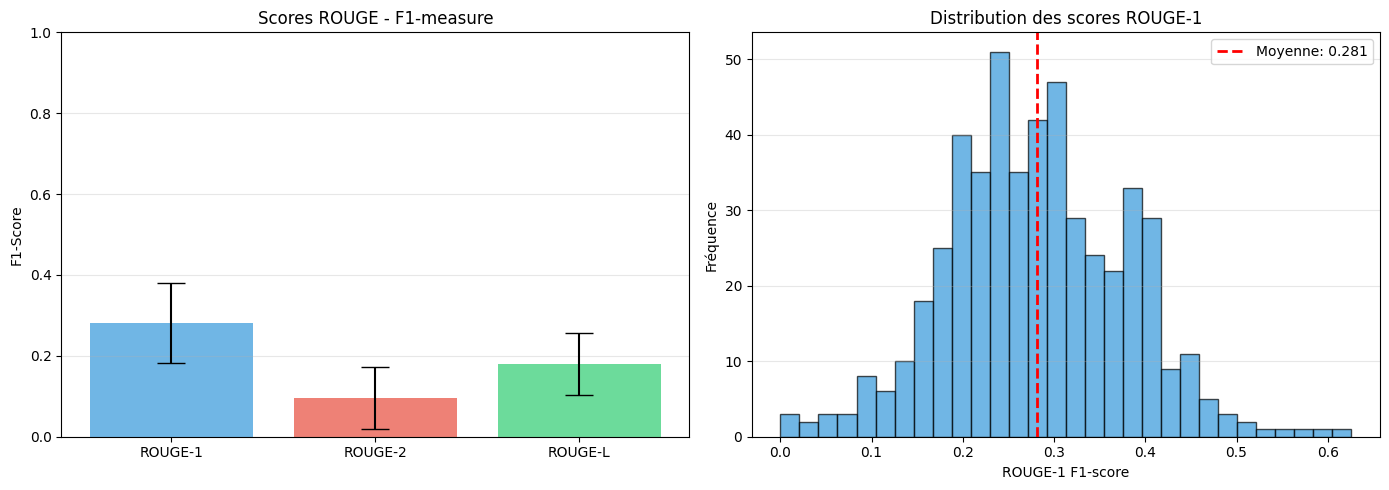


📝 COMPARAISON RÉSUMÉS GÉNÉRÉS vs RÉFÉRENCE

────────────────────────────────────────────────────────────────────────────────
EXEMPLE 1
────────────────────────────────────────────────────────────────────────────────

📰 ARTICLE ORIGINAL (798 mots):
A strong U.S. military is indispensable to our national security . As retired military officers , we have dedicated our careers , on active duty and retired , to that end . We have been involved in crafting and teaching national security strategy , of which military strategy and use of military force are vital components . In the debate over the Pentagon budget and with threats of deeper cuts comi...

🤖 RÉSUMÉ GÉNÉRÉ (TextRank, 172 mots):
A strong U.S. military is indispensable to our national security . As retired military officers , we have dedicated our careers , on active duty and retired , to that end . We have been involved in crafting and teaching national security strategy , of which military strategy and use of military force are vi

In [ ]:
# ==========================================
# PARTIE 4 : SCRIPT PRINCIPAL
# ==========================================

if __name__ == "__main__":
    """
    Exécution complète de la baseline extractive
    """

    print("🚀 Itération 1 : Baseline Extractive avec TextRank")
    print("="*60)


    # ⚙️ INITIALISATION
    print("\n🔧 Initialisation du modèle TextRank...")
    summarizer = TextRankSummarizer(
        top_n=3,  # Nombre de phrases à extraire (ajustable)
        similarity_threshold=0.1
    )

    evaluator = ROUGEEvaluator()

    # ⚙️ GÉNÉRATION DES RÉSUMÉS (sur ensemble de validation pour rapidité)
    print("\n📝 Génération des résumés extractifs...")

    # Pour commencer, évaluer sur un sous-ensemble du val_df (plus rapide)
    eval_sample_size = min(500, len(val_df))  # Ajuster selon temps disponible
    eval_df = val_df.head(eval_sample_size).copy()

    summaries = generate_summaries(eval_df, summarizer)
    eval_df['generated_summary'] = summaries

    # ⚙️ ÉVALUATION ROUGE
    print("\n📊 Évaluation avec métriques ROUGE...")
    results_df, mean_scores = evaluator.evaluate_dataset(
        predictions=summaries,
        references=eval_df['highlights'].tolist()
    )

    # ⚙️ VISUALISATION
    visualize_results(results_df)

    # ⚙️ EXEMPLES
    compare_examples(eval_df, eval_df['generated_summary'].tolist(), n=5) # Pass the column instead of the raw list

    # ⚙️ SAUVEGARDE DES RÉSULTATS
    print("\n💾 Sauvegarde des résultats...")
    eval_df.to_pickle('extractive_results.pkl')
    results_df.to_csv('rouge_scores_extractive.csv', index=False)
    mean_scores.to_csv('rouge_mean_scores_extractive.csv', header=['score'])

    print("\n" + "="*60)
    print("✨ Baseline Extractive terminée avec succès!")
    print("="*60)
    print("\n📌 Fichiers générés:")
    print("  • extractive_results.pkl - Résultats complets")
    print("  • rouge_scores_extractive.csv - Scores détaillés")
    print("  • rouge_mean_scores_extractive.csv - Scores moyens")
    print("  • rouge_scores_extractive.png - Visualisations")



#IT1-Phase2: Optimisation hyperparamètres GridSearch

In [ ]:
"""
PHASE 2 : RECHERCHE PAR GRILLE - Optimisation hyperparamètres
"""

print("\n" + "="*60)
print("🔬 PHASE 2 : RECHERCHE PAR GRILLE")
print("="*60)

# Utiliser 1500 exemples (tout le val_df disponible)
grid_sample_size = min(2000, len(val_df))  # Prendra 1500 car val_df = 1500
grid_eval_df = val_df.head(grid_sample_size).copy()

print(f"\n📊 Échantillon pour grille : {len(grid_eval_df)} exemples")

# Grille de recherche
results_grid = []

param_grid = {
    'top_n': [2, 3, 4, 5],
    'sim_threshold': [0.0, 0.1, 0.2]
}

total_configs = len(param_grid['top_n']) * len(param_grid['sim_threshold'])
print(f"🔧 Test de {total_configs} configurations\n")

from itertools import product

for i, (top_n, sim_threshold) in enumerate(product(param_grid['top_n'], param_grid['sim_threshold']), 1):
    print(f"Configuration {i}/{total_configs}: top_n={top_n}, threshold={sim_threshold}")

    # Initialiser le summarizer
    summarizer_grid = TextRankSummarizer(
        top_n=top_n,
        similarity_threshold=sim_threshold
    )

    # Générer résumés
    summaries_grid = generate_summaries(grid_eval_df, summarizer_grid)

    # Évaluer
    results_df_temp, mean_scores_temp = evaluator.evaluate_dataset(
        predictions=summaries_grid,
        references=grid_eval_df['highlights'].tolist()
    )

    # Stocker résultats
    results_grid.append({
        'top_n': top_n,
        'sim_threshold': sim_threshold,
        'rouge1': mean_scores_temp['rouge1_f'],
        'rouge2': mean_scores_temp['rouge2_f'],
        'rougeL': mean_scores_temp['rougeL_f']
    })

# Analyser les résultats
grid_results_df = pd.DataFrame(results_grid)
grid_results_df = grid_results_df.sort_values('rouge1', ascending=False)

print("\n" + "="*60)
print("📊 RÉSULTATS DE LA GRILLE DE RECHERCHE")
print("="*60)
print(grid_results_df.to_string(index=False))

# Identifier la meilleure config
best_config = grid_results_df.iloc[0]
print(f"\n⭐ MEILLEURE CONFIGURATION:")
print(f"  • top_n = {best_config['top_n']:.0f}")
print(f"  • sim_threshold = {best_config['sim_threshold']}")
print(f"  • ROUGE-1 = {best_config['rouge1']:.4f}")

# Sauvegarder
grid_results_df.to_csv(f'{project_dir}/results/grid_search_results.csv', index=False)
print(f"\n💾 Résultats sauvegardés dans {project_dir}/results/grid_search_results.csv")


🔬 PHASE 2 : RECHERCHE PAR GRILLE

📊 Échantillon pour grille : 1500 exemples
🔧 Test de 12 configurations

Configuration 1/12: top_n=2, threshold=0.0


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:04<00:00, 370.44it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2928
  Precision: 0.2489
  Recall:    0.3977

ROUGE-2:
  F1-score:  0.0932
  Precision: 0.0794
  Recall:    0.1258

ROUGE-L:
  F1-score:  0.1874
  Precision: 0.1602
  Recall:    0.2540
Configuration 2/12: top_n=2, threshold=0.1


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:03<00:00, 395.58it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2814
  Precision: 0.2515
  Recall:    0.3652

ROUGE-2:
  F1-score:  0.0882
  Precision: 0.0784
  Recall:    0.1152

ROUGE-L:
  F1-score:  0.1823
  Precision: 0.1648
  Recall:    0.2360
Configuration 3/12: top_n=2, threshold=0.2


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:05<00:00, 296.18it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2312
  Precision: 0.2251
  Recall:    0.2753

ROUGE-2:
  F1-score:  0.0570
  Precision: 0.0546
  Recall:    0.0681

ROUGE-L:
  F1-score:  0.1474
  Precision: 0.1449
  Recall:    0.1749
Configuration 4/12: top_n=3, threshold=0.0


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:07<00:00, 209.81it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2825
  Precision: 0.2074
  Recall:    0.4935

ROUGE-2:
  F1-score:  0.0975
  Precision: 0.0715
  Recall:    0.1708

ROUGE-L:
  F1-score:  0.1816
  Precision: 0.1335
  Recall:    0.3179
Configuration 5/12: top_n=3, threshold=0.1


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:06<00:00, 220.63it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2770
  Precision: 0.2107
  Recall:    0.4567

ROUGE-2:
  F1-score:  0.0918
  Precision: 0.0691
  Recall:    0.1531

ROUGE-L:
  F1-score:  0.1778
  Precision: 0.1356
  Recall:    0.2942
Configuration 6/12: top_n=3, threshold=0.2


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:06<00:00, 238.53it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2380
  Precision: 0.1924
  Recall:    0.3604

ROUGE-2:
  F1-score:  0.0600
  Precision: 0.0480
  Recall:    0.0918

ROUGE-L:
  F1-score:  0.1464
  Precision: 0.1190
  Recall:    0.2221
Configuration 7/12: top_n=4, threshold=0.0


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:08<00:00, 176.90it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2642
  Precision: 0.1786
  Recall:    0.5644

ROUGE-2:
  F1-score:  0.0976
  Precision: 0.0659
  Recall:    0.2097

ROUGE-L:
  F1-score:  0.1723
  Precision: 0.1166
  Recall:    0.3693
Configuration 8/12: top_n=4, threshold=0.1


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:12<00:00, 123.48it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2626
  Precision: 0.1830
  Recall:    0.5225

ROUGE-2:
  F1-score:  0.0908
  Precision: 0.0627
  Recall:    0.1831

ROUGE-L:
  F1-score:  0.1685
  Precision: 0.1172
  Recall:    0.3372
Configuration 9/12: top_n=4, threshold=0.2


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:11<00:00, 131.83it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2319
  Precision: 0.1676
  Recall:    0.4300

ROUGE-2:
  F1-score:  0.0621
  Precision: 0.0445
  Recall:    0.1172

ROUGE-L:
  F1-score:  0.1416
  Precision: 0.1024
  Recall:    0.2636
Configuration 10/12: top_n=5, threshold=0.0


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:10<00:00, 144.76it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2445
  Precision: 0.1568
  Recall:    0.6167

ROUGE-2:
  F1-score:  0.0948
  Precision: 0.0607
  Recall:    0.2404

ROUGE-L:
  F1-score:  0.1610
  Precision: 0.1032
  Recall:    0.4080
Configuration 11/12: top_n=5, threshold=0.1


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:08<00:00, 171.35it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2463
  Precision: 0.1616
  Recall:    0.5772

ROUGE-2:
  F1-score:  0.0887
  Precision: 0.0578
  Recall:    0.2111

ROUGE-L:
  F1-score:  0.1583
  Precision: 0.1037
  Recall:    0.3743
Configuration 12/12: top_n=5, threshold=0.2


Évaluation ROUGE: 100%|██████████| 1500/1500 [00:08<00:00, 173.91it/s]


📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2205
  Precision: 0.1485
  Recall:    0.4866

ROUGE-2:
  F1-score:  0.0620
  Precision: 0.0413
  Recall:    0.1405

ROUGE-L:
  F1-score:  0.1348
  Precision: 0.0907
  Recall:    0.2997

📊 RÉSULTATS DE LA GRILLE DE RECHERCHE
 top_n  sim_threshold   rouge1   rouge2   rougeL
     2            0.0 0.292839 0.093174 0.187436
     3            0.0 0.282494 0.097550 0.181577
     2            0.1 0.281419 0.088218 0.182253
     3            0.1 0.277026 0.091830 0.177847
     4            0.0 0.264181 0.097561 0.172326
     4            0.1 0.262574 0.090815 0.168466
     5            0.1 0.246288 0.088712 0.158328
     5            0.0 0.244507 0.094790 0.161040
     3            0.2 0.237986 0.060033 0.146427
     4            0.2 0.231917 0.062121 0.141613
     2            0.2 0.231165 0.056985 0.147402
     5            0.2 0.220522 0.062004 0.134836

⭐ MEILLEURE CONFIGURATION:
  • top_n = 2
  • sim_threshold = 0.0
  • ROUGE-1 = 0.2928

💾 R

In [ ]:
print("\n" + "="*60)
print("📊 RÉSULTATS DE LA GRILLE DE RECHERCHE")
print("="*60)
display(grid_results_df)


📊 RÉSULTATS DE LA GRILLE DE RECHERCHE


,top_n,sim_threshold,rouge1,rouge2,rougeL
0,2,0.0,0.292839,0.093174,0.187436
3,3,0.0,0.282494,0.097550,0.181577
1,2,0.1,0.281419,0.088218,0.182253
4,3,0.1,0.277026,0.091830,0.177847
6,4,0.0,0.264181,0.097561,0.172326
7,4,0.1,0.262574,0.090815,0.168466
10,5,0.1,0.246288,0.088712,0.158328
9,5,0.0,0.244507,0.094790,0.161040
5,3,0.2,0.237986,0.060033,0.146427
8,4,0.2,0.231917,0.062121,0.141613


#IT2-Phase 3 : Evaluation finale avec meilleurs params


🎯 PHASE 3 : ÉVALUATION FINALE

🔧 Configuration optimale:
  • top_n = 2
  • similarity_threshold = 0.0

📊 Échantillon final : 10000 exemples

📝 Génération des résumés finaux...


Génération résumés: 100%|██████████| 10000/10000 [01:00<00:00, 166.27it/s]



📊 Évaluation ROUGE finale...


Évaluation ROUGE: 100%|██████████| 10000/10000 [00:32<00:00, 311.70it/s]



📊 SCORES ROUGE MOYENS

ROUGE-1:
  F1-score:  0.2941
  Precision: 0.2499
  Recall:    0.4009

ROUGE-2:
  F1-score:  0.0927
  Precision: 0.0788
  Recall:    0.1261

ROUGE-L:
  F1-score:  0.1885
  Precision: 0.1610
  Recall:    0.2566

📊 Graphiques sauvegardés dans 'rouge_scores_extractive.png'


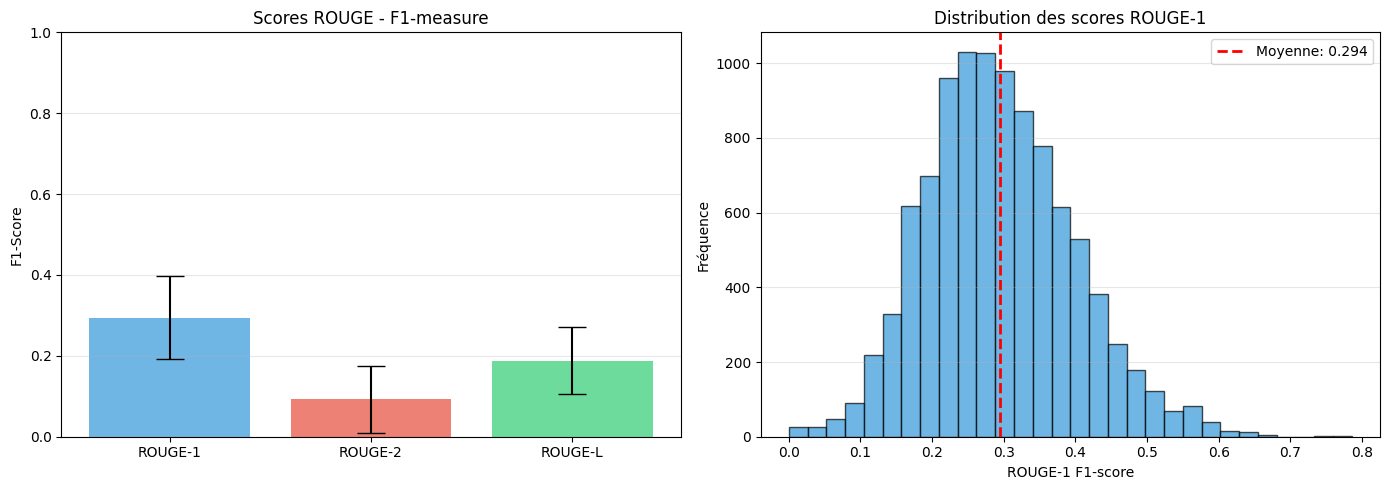


📝 COMPARAISON RÉSUMÉS GÉNÉRÉS vs RÉFÉRENCE

────────────────────────────────────────────────────────────────────────────────
EXEMPLE 1
────────────────────────────────────────────────────────────────────────────────

📰 ARTICLE ORIGINAL (1624 mots):
-LRB- CNN -RRB- -- The first wave of India 's 814 million eligible voters cast their ballots in the remote northeastern states of Assam and Tripura Monday , as the largest election in world history got underway . Any time the world 's most populous democracy goes to the polls , it 's a momentous undertaking . But with Prime Minister Manmohan Singh stepping aside after a decade in charge , analysts...

🤖 RÉSUMÉ GÉNÉRÉ (TextRank, 114 mots):
Yet any misgivings about Modi have so far failed to buoy the prospects of the Congress candidate Rahul Gandhi . With an unparalleled political pedigree as the son of assassinated former prime minister Rajiv Gandhi and the Italy-born Congress Party president Sonia Gandhi , the 43-year-old has long been view

In [ ]:
phased_text = """
PHASE 3 : ÉVALUATION FINALE - Test avec meilleurs paramètres
"""

print("\n" + "="*60)
print("🎯 PHASE 3 : ÉVALUATION FINALE")
print("="*60)

# Utiliser les meilleurs paramètres trouvés dans la grille
# (ou définir manuellement si tu sais déjà : top_n=2, threshold=0.0)
best_top_n = int(best_config['top_n'])
best_threshold = best_config['sim_threshold']

print(f"\n🔧 Configuration optimale:")
print(f"  • top_n = {best_top_n}")
print(f"  • similarity_threshold = {best_threshold}")

# Créer échantillon de test de 10000 exemples
# Stratégie : combiner train + val + test si nécessaire
all_data = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

final_sample_size = min(10000, len(all_data))
final_eval_df = all_data.head(final_sample_size).copy()

print(f"\n📊 Échantillon final : {len(final_eval_df)} exemples")

# Initialiser le summarizer final
summarizer_final = TextRankSummarizer(
    top_n=best_top_n,
    similarity_threshold=best_threshold
)

# Générer résumés
print("\n📝 Génération des résumés finaux...")
summaries_final = generate_summaries(final_eval_df, summarizer_final)

# Ajoutez la colonne 'generated_summary' au DataFrame AVANT d'appeler compare_examples
final_eval_df['generated_summary'] = summaries_final

# Évaluation ROUGE
print("\n📊 Évaluation ROUGE finale...")
results_final, mean_final = evaluator.evaluate_dataset(
    predictions=summaries_final,
    references=final_eval_df['highlights'].tolist()
)

# Visualisation
visualize_results(results_final)

# Exemples comparatifs
compare_examples(final_eval_df, summaries_final, n=5)

# Sauvegarder résultats finaux
print("\n💾 Sauvegarde des résultats finaux...")
final_eval_df.to_pickle(f'{project_dir}/results/extractive_final_results.pkl')
results_final.to_csv(f'{project_dir}/results/rouge_final_scores.csv', index=False)
mean_final.to_csv(f'{project_dir}/results/rouge_final_mean.csv', header=['score'])

print("\n" + "="*60)
print("✨ ÉVALUATION FINALE TERMINÉE")
print("="*60)
print(f"\n📈 SCORES FINAUX (sur {len(final_eval_df)} exemples):")
print(f"  • ROUGE-1: {mean_final['rouge1_f']:.4f}")
print(f"  • ROUGE-2: {mean_final['rouge2_f']:.4f}")
print(f"  • ROUGE-L: {mean_final['rougeL_f']:.4f}")

##Résultats IT1

### Distribution des scores ROUGE-1 F1 (Histogramme)

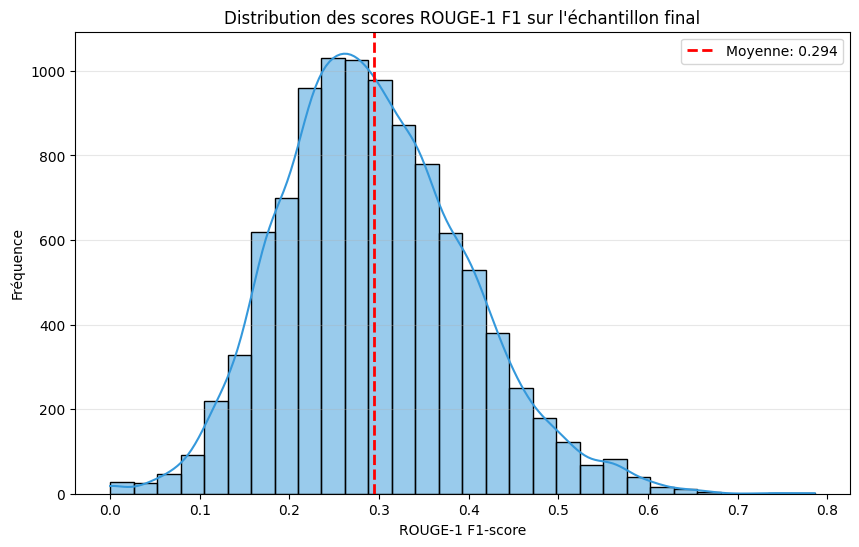

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(results_final['rouge1_f'], bins=30, kde=True, color='#3498db', edgecolor='black')
plt.axvline(results_final['rouge1_f'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {results_final["rouge1_f"].mean():.3f}')
plt.title('Distribution des scores ROUGE-1 F1 sur l\'échantillon final')
plt.xlabel('ROUGE-1 F1-score')
plt.ylabel('Fréquence')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

### Heatmap des scores ROUGE-1 F1 par `top_n` et `sim_threshold`

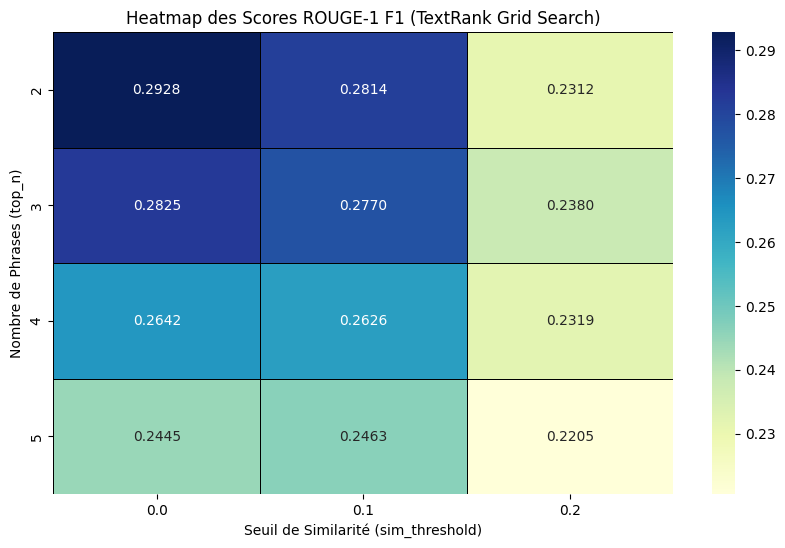

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer une pivot table pour les scores ROUGE-1 F1
heatmap_data_rouge1 = grid_results_df.pivot_table(
    index='top_n',
    columns='sim_threshold',
    values='rouge1'
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data_rouge1,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    linewidths=.5,
    linecolor='black'
)
plt.title('Heatmap des Scores ROUGE-1 F1 (TextRank Grid Search)')
plt.xlabel('Seuil de Similarité (sim_threshold)')
plt.ylabel('Nombre de Phrases (top_n)')
plt.show()

### Comparaison Precision/Recall (Nuage de Points)

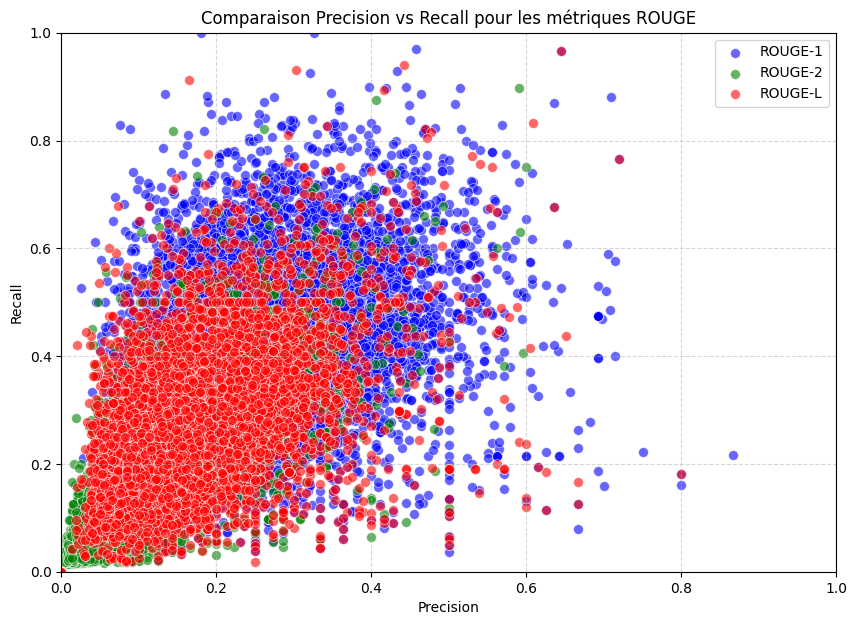

In [ ]:
plt.figure(figsize=(10, 7))

# ROUGE-1
sns.scatterplot(
    x=results_final['rouge1_p'],
    y=results_final['rouge1_r'],
    label='ROUGE-1',
    alpha=0.6,
    s=50,
    color='blue'
)
# ROUGE-2
sns.scatterplot(
    x=results_final['rouge2_p'],
    y=results_final['rouge2_r'],
    label='ROUGE-2',
    alpha=0.6,
    s=50,
    color='green'
)
# ROUGE-L
sns.scatterplot(
    x=results_final['rougeL_p'],
    y=results_final['rougeL_r'],
    label='ROUGE-L',
    alpha=0.6,
    s=50,
    color='red'
)

plt.title('Comparaison Precision vs Recall pour les métriques ROUGE')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Exemples qualitatifs de résumés

In [ ]:
# Afficher 5 exemples comparatifs de l'évaluation finale
compare_examples(final_eval_df, summaries_final, n=5)


📝 COMPARAISON RÉSUMÉS GÉNÉRÉS vs RÉFÉRENCE

────────────────────────────────────────────────────────────────────────────────
EXEMPLE 1
────────────────────────────────────────────────────────────────────────────────

📰 ARTICLE ORIGINAL (1624 mots):
-LRB- CNN -RRB- -- The first wave of India 's 814 million eligible voters cast their ballots in the remote northeastern states of Assam and Tripura Monday , as the largest election in world history got underway . Any time the world 's most populous democracy goes to the polls , it 's a momentous undertaking . But with Prime Minister Manmohan Singh stepping aside after a decade in charge , analysts...

🤖 RÉSUMÉ GÉNÉRÉ (TextRank, 114 mots):
Yet any misgivings about Modi have so far failed to buoy the prospects of the Congress candidate Rahul Gandhi . With an unparalleled political pedigree as the son of assassinated former prime minister Rajiv Gandhi and the Italy-born Congress Party president Sonia Gandhi , the 43-year-old has long been view